Projeto Final - Processamento de Linguagem Natural

Aplicação de Técnicas de PLN para Detecção de Plágio em Documentos

Baseado no artigo "Using Natural Language Processing for Automatic Detection of Plagiarism"

Alunos: Renan Baisso 11064215, Yago Sorrilha 11047514

In [493]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import os
import pandas as pd
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\renan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\renan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [494]:
def sentence_segmentation (string):
    segmented_string = nltk.sent_tokenize(string)
    return segmented_string

In [495]:
def string_without_punct(string):
    regex_punctuation = r'[^\w\s]'
    string_without_punct = re.sub(regex_punctuation,'',string)
    return string_without_punct

In [496]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.VERB)


In [497]:
def lemmatizer(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for w in words:
        lemmas.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
    return lemmas


In [498]:
def tokenizer(string):
    #https://www.w3schools.com/python/python_regex.asp#findall
    regex = r"\b[-a-zA-ZÀ-ÖØ-öø-ÿ0-9]+\b"
    return re.findall(regex, string)

In [499]:
def normalizer(word):
    return [ w.lower() for w in word]

In [500]:
class PorterStemmerCustom:
    #https://tartarus.org/martin/PorterStemmer/python.txt
    def isCons(self, letter):
        if letter == 'a' or letter == 'e' or letter == 'i' or letter == 'o' or letter == 'u':
            return False
        else:
            return True

    def isConsonant(self, word, i):
        letter = word[i]
        if self.isCons(letter):
            if letter == 'y' and self.isCons(word[i-1]):
                return False
            else:
                return True
        else:
            return False

    def isVowel(self, word, i):
        return not(self.isConsonant(word, i))

    # *S
    def endsWith(self, stem, letter):
        if stem.endswith(letter):
            return True
        else:
            return False

    # *v*
    def containsVowel(self, stem):
        for i in stem:
            if not self.isCons(i):
                return True
        return False

    # *d
    def doubleCons(self, stem):
        if len(stem) >= 2:
            if self.isConsonant(stem, -1) and self.isConsonant(stem, -2):
                return True
            else:
                return False
        else:
            return False

    def getForm(self, word):
        form = []
        formStr = ''
        for i in range(len(word)):
            if self.isConsonant(word, i):
                if i != 0:
                    prev = form[-1]
                    if prev != 'C':
                        form.append('C')
                else:
                    form.append('C')
            else:
                if i != 0:
                    prev = form[-1]
                    if prev != 'V':
                        form.append('V')
                else:
                    form.append('V')
        for j in form:
            formStr += j
        return formStr

    def getM(self, word):
        form = self.getForm(word)
        m = form.count('VC')
        return m

    # *o
    def cvc(self, word):
        if len(word) >= 3:
            f = -3
            s = -2
            t = -1
            third = word[t]
            if self.isConsonant(word, f) and self.isVowel(word, s) and self.isConsonant(word, t):
                if third != 'w' and third != 'x' and third != 'y':
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def replace(self, orig, rem, rep):
        result = orig.rfind(rem)
        base = orig[:result]
        replaced = base + rep
        return replaced

    def replaceM0(self, orig, rem, rep):
        result = orig.rfind(rem)
        base = orig[:result]
        if self.getM(base) > 0:
            replaced = base + rep
            return replaced
        else:
            return orig

    def replaceM1(self, orig, rem, rep):
        result = orig.rfind(rem)
        base = orig[:result]
        if self.getM(base) > 1:
            replaced = base + rep
            return replaced
        else:
            return orig

    def step1a(self, word):
        if word.endswith('sses'):
            word = self.replace(word, 'sses', 'ss')
        elif word.endswith('ies'):
            word = self.replace(word, 'ies', 'i')
        elif word.endswith('ss'):
            word = self.replace(word, 'ss', 'ss')
        elif word.endswith('s'):
            word = self.replace(word, 's', '')
        else:
            pass
        return word

    def step1b(self, word):
        flag = False
        if word.endswith('eed'):
            result = word.rfind('eed')
            base = word[:result]
            if self.getM(base) > 0:
                word = base
                word += 'ee'
        elif word.endswith('ed'):
            result = word.rfind('ed')
            base = word[:result]
            if self.containsVowel(base):
                word = base
                flag = True
        elif word.endswith('ing'):
            result = word.rfind('ing')
            base = word[:result]
            if self.containsVowel(base):
                word = base
                flag = True
        if flag:
            if word.endswith('at') or word.endswith('bl') or word.endswith('iz'):
                word += 'e'
            elif self.doubleCons(word) and not self.endsWith(word, 'l') and not self.endsWith(word, 's') and not self.endsWith(word, 'z'):
                word = word[:-1]
            elif self.getM(word) == 1 and self.cvc(word):
                word += 'e'
            else:
                pass
        else:
            pass
        return word

    def step1c(self, word):
        if word.endswith('y'):
            result = word.rfind('y')
            base = word[:result]
            if self.containsVowel(base):
                word = base
                word += 'i'
        return word

    def step2(self, word):
        if word.endswith('ational'):
            word = self.replaceM0(word, 'ational', 'ate')
        elif word.endswith('tional'):
            word = self.replaceM0(word, 'tional', 'tion')
        elif word.endswith('enci'):
            word = self.replaceM0(word, 'enci', 'ence')
        elif word.endswith('anci'):
            word = self.replaceM0(word, 'anci', 'ance')
        elif word.endswith('izer'):
            word = self.replaceM0(word, 'izer', 'ize')
        elif word.endswith('abli'):
            word = self.replaceM0(word, 'abli', 'able')
        elif word.endswith('alli'):
            word = self.replaceM0(word, 'alli', 'al')
        elif word.endswith('entli'):
            word = self.replaceM0(word, 'entli', 'ent')
        elif word.endswith('eli'):
            word = self.replaceM0(word, 'eli', 'e')
        elif word.endswith('ousli'):
            word = self.replaceM0(word, 'ousli', 'ous')
        elif word.endswith('ization'):
            word = self.replaceM0(word, 'ization', 'ize')
        elif word.endswith('ation'):
            word = self.replaceM0(word, 'ation', 'ate')
        elif word.endswith('ator'):
            word = self.replaceM0(word, 'ator', 'ate')
        elif word.endswith('alism'):
            word = self.replaceM0(word, 'alism', 'al')
        elif word.endswith('iveness'):
            word = self.replaceM0(word, 'iveness', 'ive')
        elif word.endswith('fulness'):
            word = self.replaceM0(word, 'fulness', 'ful')
        elif word.endswith('ousness'):
            word = self.replaceM0(word, 'ousness', 'ous')
        elif word.endswith('aliti'):
            word = self.replaceM0(word, 'aliti', 'al')
        elif word.endswith('iviti'):
            word = self.replaceM0(word, 'iviti', 'ive')
        elif word.endswith('biliti'):
            word = self.replaceM0(word, 'biliti', 'ble')
        return word

    def step3(self, word):
        if word.endswith('icate'):
            word = self.replaceM0(word, 'icate', 'ic')
        elif word.endswith('ative'):
            word = self.replaceM0(word, 'ative', '')
        elif word.endswith('alize'):
            word = self.replaceM0(word, 'alize', 'al')
        elif word.endswith('iciti'):
            word = self.replaceM0(word, 'iciti', 'ic')
        elif word.endswith('ful'):
            word = self.replaceM0(word, 'ful', '')
        elif word.endswith('ness'):
            word = self.replaceM0(word, 'ness', '')
        return word

    def step4(self, word):
        if word.endswith('al'):
            word = self.replaceM1(word, 'al', '')
        elif word.endswith('ance'):
            word = self.replaceM1(word, 'ance', '')
        elif word.endswith('ence'):
            word = self.replaceM1(word, 'ence', '')
        elif word.endswith('er'):
            word = self.replaceM1(word, 'er', '')
        elif word.endswith('ic'):
            word = self.replaceM1(word, 'ic', '')
        elif word.endswith('able'):
            word = self.replaceM1(word, 'able', '')
        elif word.endswith('ible'):
            word = self.replaceM1(word, 'ible', '')
        elif word.endswith('ant'):
            word = self.replaceM1(word, 'ant', '')
        elif word.endswith('ement'):
            word = self.replaceM1(word, 'ement', '')
        elif word.endswith('ment'):
            word = self.replaceM1(word, 'ment', '')
        elif word.endswith('ent'):
            word = self.replaceM1(word, 'ent', '')
        elif word.endswith('ou'):
            word = self.replaceM1(word, 'ou', '')
        elif word.endswith('ism'):
            word = self.replaceM1(word, 'ism', '')
        elif word.endswith('ate'):
            word = self.replaceM1(word, 'ate', '')
        elif word.endswith('iti'):
            word = self.replaceM1(word, 'iti', '')
        elif word.endswith('ous'):
            word = self.replaceM1(word, 'ous', '')
        elif word.endswith('ive'):
            word = self.replaceM1(word, 'ive', '')
        elif word.endswith('ize'):
            word = self.replaceM1(word, 'ize', '')
        elif word.endswith('ion'):
            result = word.rfind('ion')
            base = word[:result]
            if self.getM(base) > 1 and (self.endsWith(base, 's') or self.endsWith(base, 't')):
                word = base
            word = self.replaceM1(word, '', '')
        return word

    def step5a(self, word):
        if word.endswith('e'):
            base = word[:-1]
            if self.getM(base) > 1:
                word = base
            elif self.getM(base) == 1 and not self.cvc(base):
                word = base
        return word

    def step5b(self, word):
        if self.getM(word) > 1 and self.doubleCons(word) and self.endsWith(word, 'l'):
            word = word[:-1]
        return word

    def stem(self, word):
        word = self.step1a(word)
        word = self.step1b(word)
        word = self.step1c(word)
        word = self.step2(word)
        word = self.step3(word)
        word = self.step4(word)
        word = self.step5a(word)
        word = self.step5b(word)
        return word

In [501]:
def stemArray(words):
    psc = PorterStemmerCustom()
    result = []
    for w in words:
        result.append(psc.stem(w))
    return result    

In [502]:
class StopWordsHandler:
    #https://stackoverflow.com/questions/6022764/python-removing-list-element-while-iterating-over-list/6024599
    #https://gist.github.com/sebleier/554280
    def isStopWord(self,word):
        stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
        if word in stop_words:
            return True
        else:
            return False
    def removeStopWords(self,words):
        for i in list(words):
            if self.isStopWord(i) or i == '':
                words.remove(i)
            else:
                pass
        return words

In [503]:
def readCorpusData(path):
    files = []
    read_tuples = []
    #Lendo arquivos da pasta data/
    for r, d, f in os.walk(path):
        for file in f:
            #Caso seja .xls, eh o excel que possui os as respostas para o treinamento
            if '.xls' in file:
                xls = pd.ExcelFile(f'{path}{file}')
                #Transformar em DataFrame
                df = xls.parse('File list')
            elif '.txt' in file:
                with open(f'{path}{file}', 'r', encoding="utf8", errors='ignore') as j:
                    #Montar um lista de tuplas para mapear arquivo e conteudos
                    read_tuples.append((file, j.read()))

    #Transformar lista de tuplas em DF
    df_tuples = pd.DataFrame(read_tuples, columns=['File', 'Content'])
    #Realizar o Join entre os arquivos para mapear conteudo e respostas de treinamento
    return pd.merge(df_tuples, df, how='left', left_on = 'File', right_on = 'File')

In [504]:
path = 'data/'
corpusDF = readCorpusData(path)
corpusDF = corpusDF[['File', 'Category','Content']]
corpusDF.head()

,File,Category,Content
0,g0pA_taska.txt,non,Inheritance is a basic concept of Object-Orien...
1,g0pA_taskb.txt,cut,PageRank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,light,"The vector space model (also called, term vect..."
3,g0pA_taskd.txt,heavy,Bayes’ theorem was names after Rev Thomas Baye...
4,g0pA_taske.txt,non,Dynamic Programming is an algorithm design tec...


In [505]:
corpusDF.describe()

,File,Category,Content
count,100,95,100
unique,100,4,100
top,g3pC_taskd.txt,non,Inheritance allows programs developed in an Ob...
freq,1,38,1


In [506]:
taska = corpusDF[corpusDF.File.str.contains('taska.txt')].fillna(0)
taskb = corpusDF[corpusDF.File.str.contains('taskb.txt')].fillna(0)
taskc = corpusDF[corpusDF.File.str.contains('taskc.txt')].fillna(0)
taskd = corpusDF[corpusDF.File.str.contains('taskd.txt')].fillna(0)
taske = corpusDF[corpusDF.File.str.contains('taske.txt')].fillna(0)

In [507]:
def wordCount(words):
    count= nltk.defaultdict(int)
    for word in words:
        count[word] += 1
    return count

In [508]:
def cos_dist(v1, v2):
    import numpy as np
    product = np.dot(v1,v2)
    
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    return product/(norm_v2*norm_v1)    

In [509]:
def getSim(t1, t2):
    import numpy as np
    vocabulary = []
    
    for key in t1:
        vocabulary.append(key)
    for key in t2:
        vocabulary.append(key)
    
    vocabulary_size = len(vocabulary)
    
    d1 = np.zeros(vocabulary_size, dtype=np.int)
    d2 = np.zeros(vocabulary_size, dtype=np.int)
    
    i = 0
    for (k) in vocabulary:
        d1[i] = t1.get(k, 0)
        d2[i] = t2.get(k, 0)
        i += 1

    return cos_dist(d1, d2)

In [510]:
def createF1(task):
    task['Tokens'] = task['Content'].map(tokenizer).map(normalizer)
    task['WCount'] = task['Tokens'].map(wordCount)
    task['f1'] = task.WCount.map(lambda t: getSim(task.WCount.iloc[-1], t))

In [511]:
def createF2(task):
    task['Tokens'] = task['Content'].map(tokenizer).map(normalizer)
    swh = StopWordsHandler()
    task['StopWordsOut'] = task['Tokens'].map(swh.removeStopWords)
    task['WCount'] = task['StopWordsOut'].map(wordCount)
    task['f2'] = task.WCount.map(lambda t: getSim(task.WCount.iloc[-1], t))

In [512]:
def createF3(task):
    ps = PorterStemmerCustom()
    task['Tokens'] = task['Content'].map(tokenizer).map(normalizer)
    swh = StopWordsHandler()
    task['StopWordsOut'] = task['Tokens'].map(swh.removeStopWords)
    task['Stem'] = task['StopWordsOut'].map(stemArray)
    task['WCount'] = task['Stem'].map(wordCount)
    task['f3'] = task.WCount.map(lambda t: getSim(task.WCount.iloc[-1], t))

In [513]:
def createF4(task):
    ps = PorterStemmerCustom()
    task['Tokens'] = task['Content'].map(tokenizer).map(normalizer)
    swh = StopWordsHandler()
    task['StopWordsOut'] = task['Tokens'].map(swh.removeStopWords)
    task['Lem'] = task['StopWordsOut'].map(lemmatizer)
    task['WCount'] = task['Lem'].map(wordCount)
    task['f4'] = task.WCount.map(lambda t: getSim(task.WCount.iloc[-1], t))

In [514]:
path = 'data/'
corpusDF = readCorpusData(path)
corpusDF = corpusDF[['File', 'Category','Content']]

In [515]:
taska = corpusDF[corpusDF.File.str.contains('taska.txt')].fillna(0)
taskb = corpusDF[corpusDF.File.str.contains('taskb.txt')].fillna(0)
taskc = corpusDF[corpusDF.File.str.contains('taskc.txt')].fillna(0)
taskd = corpusDF[corpusDF.File.str.contains('taskd.txt')].fillna(0)
taske = corpusDF[corpusDF.File.str.contains('taske.txt')].fillna(0)

In [516]:
createF1(taska)
createF1(taskb)
createF1(taskc)
createF1(taskd)
createF1(taske)

In [517]:
createF2(taska)
createF2(taskb)
createF2(taskc)
createF2(taskd)
createF2(taske)

In [518]:
createF3(taska)
createF3(taskb)
createF3(taskc)
createF3(taskd)
createF3(taske)

In [519]:
createF4(taska)
createF4(taskb)
createF4(taskc)
createF4(taskd)
createF4(taske)

In [520]:
taska.drop(taska.index[-1], inplace=True)
taskb.drop(taskb.index[-1], inplace=True)
taskc.drop(taskc.index[-1], inplace=True)
taskd.drop(taskd.index[-1], inplace=True)
taske.drop(taske.index[-1], inplace=True)

frames = [taska, taskb, taskc, taskd, taske]

df = pd.concat(frames)


In [521]:
df = df.drop(columns=['Content', 'Tokens', 'WCount', 'StopWordsOut', 'Stem', 'Lem'])
df.head()
#f1 - Apenas tokenizacao
#f2 - Tokenizacao + StopWords Removal
#f3 - Tokenizacao + StopWords Removal + Stemming
#f4 - Tokenizacao + StopWords Removal + Segmentacao + Lemmatizacao

,File,Category,f1,f2,f3,f4
0,g0pA_taska.txt,non,0.645986,0.439486,0.509229,0.495879
5,g0pB_taska.txt,non,0.658039,0.186013,0.536226,0.467069
10,g0pC_taska.txt,heavy,0.838993,0.727802,0.775872,0.755284
15,g0pD_taska.txt,cut,0.938483,0.876625,0.902144,0.885649
20,g0pE_taska.txt,light,0.993699,0.985442,0.988046,0.987032


In [522]:
df.describe()

,f1,f2,f3,f4
count,95.000000,95.000000,95.000000,95.000000
mean,0.829516,0.677044,0.733911,0.723926
std,0.104126,0.195469,0.157721,0.164721
min,0.504559,0.173395,0.337205,0.273117
25%,0.784752,0.552883,0.625465,0.605653
50%,0.838993,0.673948,0.728831,0.719417
75%,0.904170,0.832255,0.860007,0.857819
max,0.999229,0.997983,0.998351,0.998337


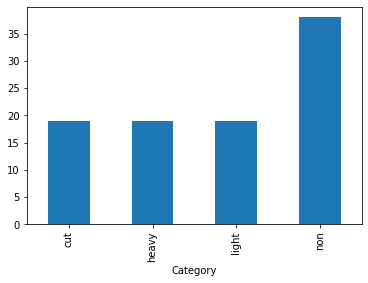

In [524]:
df.groupby('Category')['f1'].nunique().plot(kind='bar')

In [537]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

features = ['f1', 'f2', 'f3', 'f4']
target = ['Category']
def NBProcess(df, target, features):
    #X features que utilizaremos para treinar o modelo
    X = df[features] 

    #Y variável resposta, no caso nível de plágio
    y = df[target]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2) 

    gauss = GaussianNB()

    gauss.fit(X_train, y_train)

    y_pred = gauss.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)

    print('Matriz de confusão:')
    print(metrics.confusion_matrix(y_test, y_pred))
    print()
    print(f'Acurácia da classificação: {accuracy*100}%')
    print('Resumo da classificação:')
    print(metrics.classification_report(y_test, y_pred))

In [538]:
NBProcess(df, target, features)

Matriz de confusão:
[[0 3 1 1]
 [0 3 1 1]
 [0 0 0 0]
 [0 0 1 8]]

Acurácia da classificação: 57.89473684210527%
Resumo da classificação:
              precision    recall  f1-score   support

         cut       0.00      0.00      0.00         5
       heavy       0.50      0.60      0.55         5
       light       0.00      0.00      0.00         0
         non       0.80      0.89      0.84         9

    accuracy                           0.58        19
   macro avg       0.33      0.37      0.35        19
weighted avg       0.51      0.58      0.54        19



C:\Users\renan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\renan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\renan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [531]:
df_shuff = df.sample(frac=1, random_state=2)

non_df = df_shuff.loc[df_shuff['Category'] == 'non']
df_shuff = df_shuff[df_shuff['Category'] != 'non']

non_df = non_df.sample(n=19, random_state=5)

balanced_df = pd.concat([non_df, df_shuff])

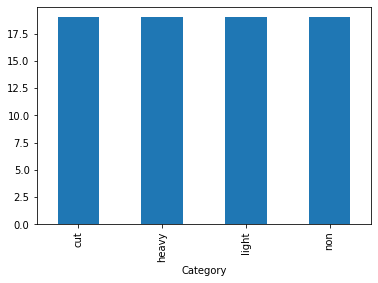

In [533]:
balanced_df.groupby('Category')['f1'].nunique().plot(kind='bar')

In [539]:
NBProcess(balanced_df, target, features)

Matriz de confusão:
[[0 1 0 1]
 [4 3 0 0]
 [2 2 0 1]
 [0 1 0 1]]

Acurácia da classificação: 25.0%
Resumo da classificação:
              precision    recall  f1-score   support

         cut       0.00      0.00      0.00         2
       heavy       0.43      0.43      0.43         7
       light       0.00      0.00      0.00         5
         non       0.33      0.50      0.40         2

    accuracy                           0.25        16
   macro avg       0.19      0.23      0.21        16
weighted avg       0.23      0.25      0.24        16



C:\Users\renan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\renan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
